In [33]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [34]:
!pip install mlflow

In [35]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score ,precision_score,recall_score,f1_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.metrics import roc_curve, auc

In [36]:
train_transaction = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")

In [37]:
train_identity = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

In [38]:
data = train_transaction.merge(train_identity, on='TransactionID', how='left')

# Preproccesing

In [39]:
missing_percentage = data.isnull().mean() * 100

In [40]:
threshold = 80

columns_to_drop = missing_percentage[missing_percentage > threshold].index

data= data.drop(columns=columns_to_drop)

In [41]:
num_cols = data.select_dtypes(include='number').columns
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

In [42]:
cat_cols = data.select_dtypes(include='object').columns
data[cat_cols] = data[cat_cols].fillna(data[cat_cols].mode().iloc[0])

In [43]:
non_numerical_columns = data.select_dtypes(include=['object', 'category'])

non_numerical_column_names = non_numerical_columns.columns.tolist()

print(non_numerical_column_names)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [44]:
# data.drop(data['DeviceInfo'], inplace= True)

categorical_cols = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType','DeviceInfo']
le = LabelEncoder()
for column in categorical_cols:
    data[column] = le.fit_transform(data[column].astype(str))

In [45]:
numerical_cols = ['TransactionAmt', 'TransactionDT']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

In [46]:
X = data.drop(['isFraud', 'TransactionID' ], axis=1)
y = data['isFraud']
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, shuffle=True, random_state=42)

# Visualizations 

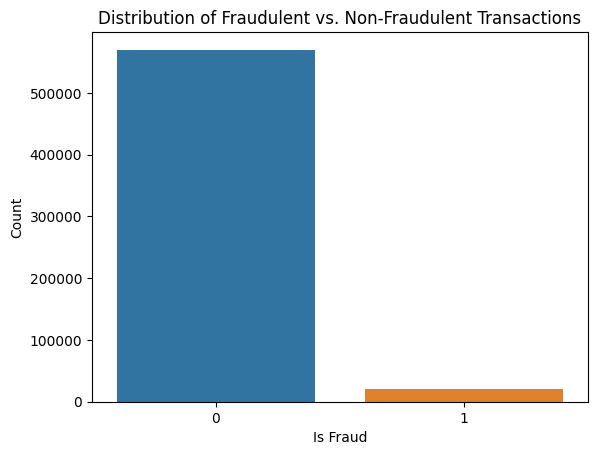

In [48]:
sns.countplot(x='isFraud', data=data)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

/tmp/ipykernel_30/3453469952.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['TransactionDayOfWeek'] = data['TransactionDT'].dt.dayofweek


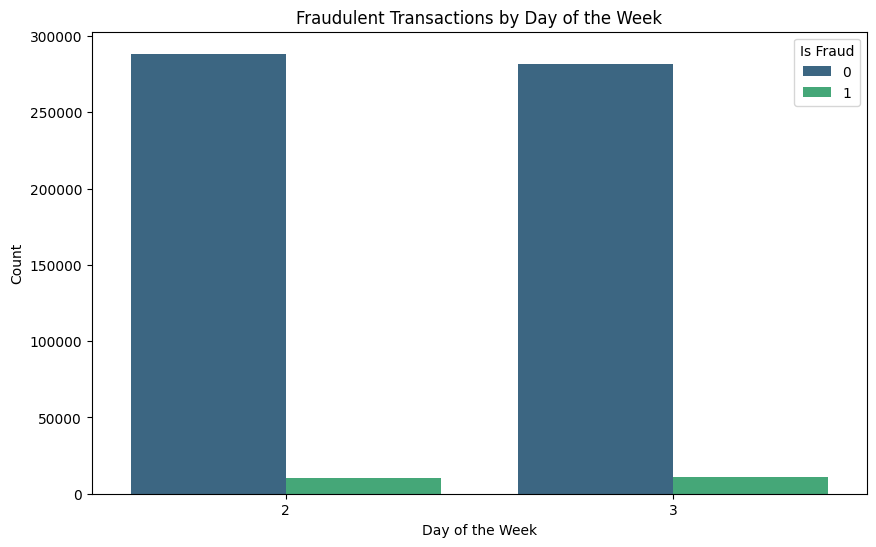

In [49]:
data['TransactionDT'] = pd.to_datetime(data['TransactionDT'], unit='s')

data['TransactionDayOfWeek'] = data['TransactionDT'].dt.dayofweek

plt.figure(figsize=(10, 6))
sns.countplot(x='TransactionDayOfWeek', hue='isFraud', data=data, palette='viridis')
plt.title('Fraudulent Transactions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.legend(title='Is Fraud')
plt.show()

/tmp/ipykernel_30/3645308720.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['TransactionHour'] = data['TransactionDT'].dt.hour


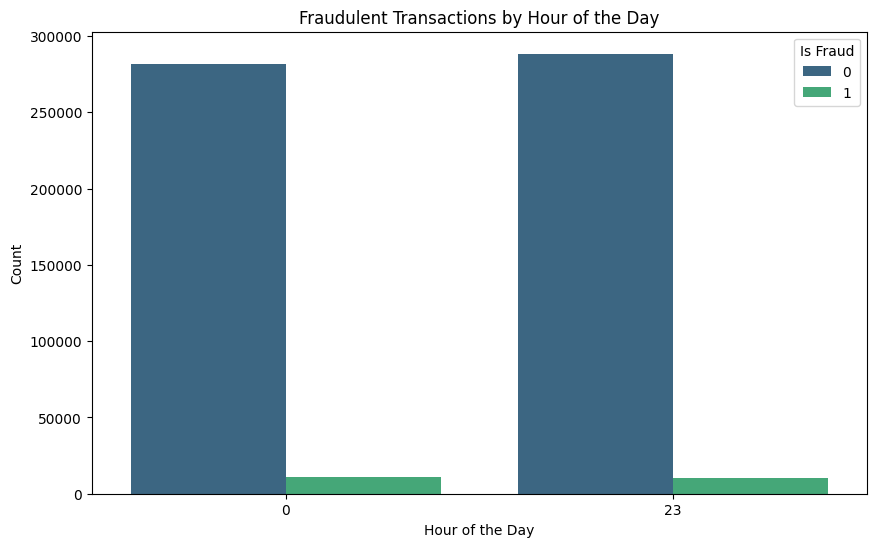

In [50]:
data['TransactionHour'] = data['TransactionDT'].dt.hour
plt.figure(figsize=(10, 6))
sns.countplot(x='TransactionHour', hue='isFraud', data=data, palette='viridis')
plt.title('Fraudulent Transactions by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.legend(title='Is Fraud')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

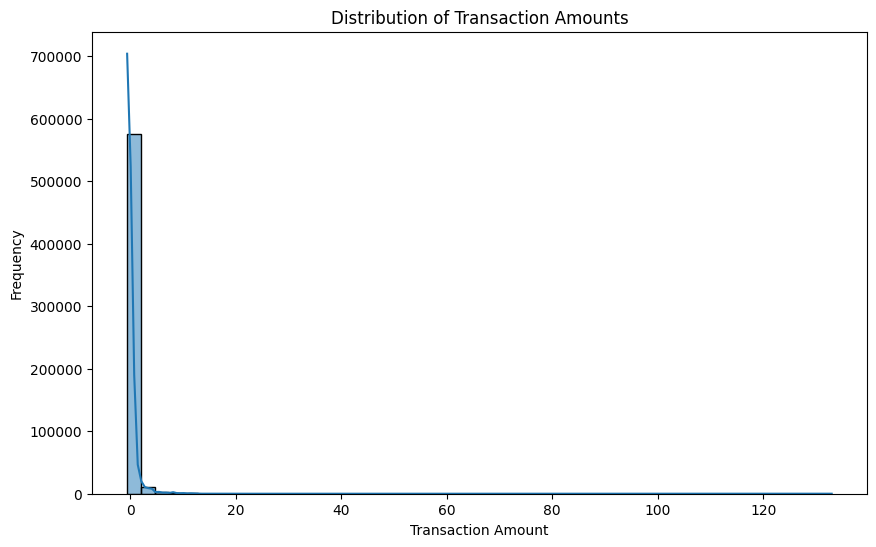

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(data['TransactionAmt'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

/tmp/ipykernel_30/1757503524.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['LogTransactionAmt'] = np.log1p(data['TransactionAmt'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


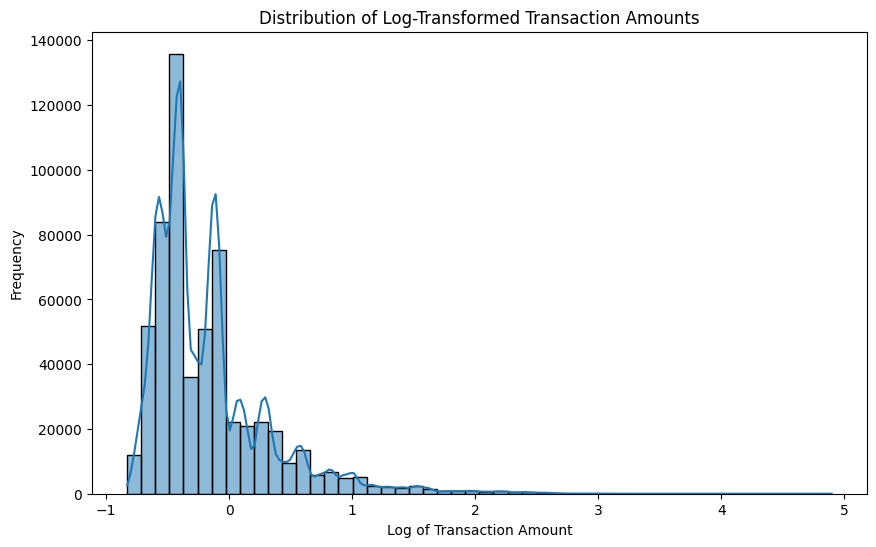

In [52]:
data['LogTransactionAmt'] = np.log1p(data['TransactionAmt'])
plt.figure(figsize=(10, 6))
sns.histplot(data['LogTransactionAmt'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Transaction Amounts')
plt.xlabel('Log of Transaction Amount')
plt.ylabel('Frequency')
plt.show()


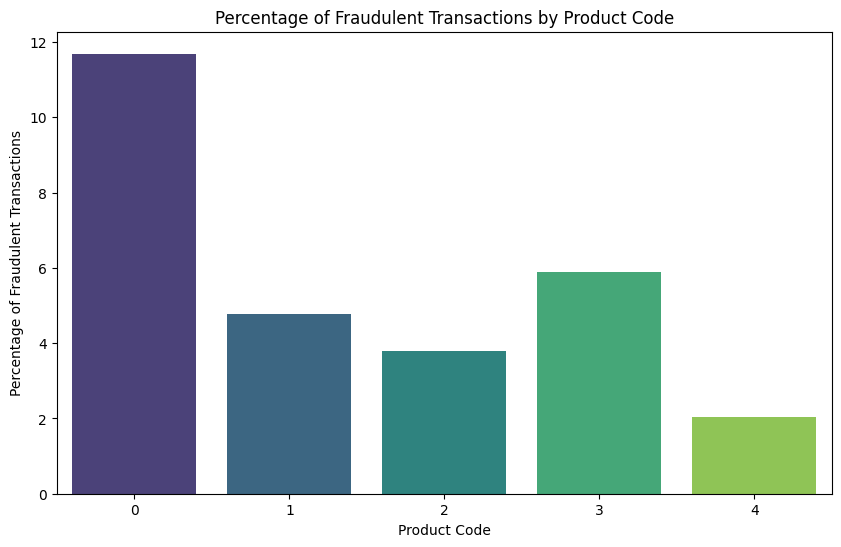

In [53]:
fraud_pct_by_product = data.groupby('ProductCD')['isFraud'].mean() * 100
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_pct_by_product.index, y=fraud_pct_by_product.values, palette='viridis')
plt.title('Percentage of Fraudulent Transactions by Product Code')
plt.xlabel('Product Code')
plt.ylabel('Percentage of Fraudulent Transactions')
plt.show()

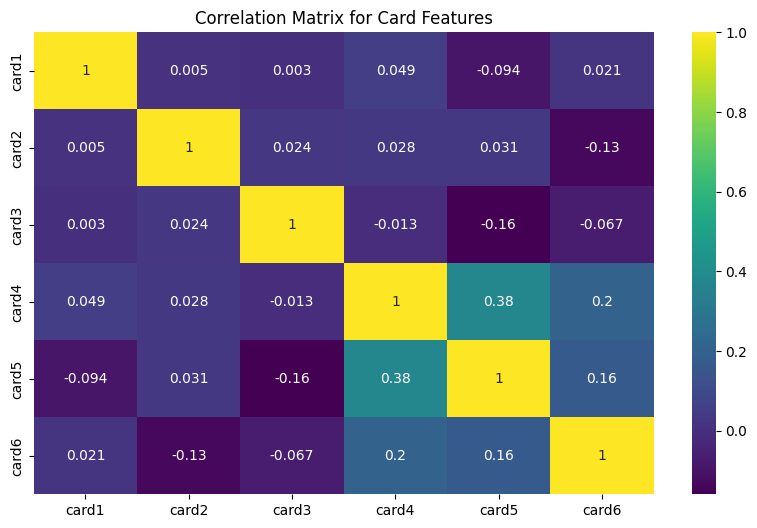

In [54]:
card_features = data[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']]
corr_matrix = card_features.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix for Card Features')
plt.show()

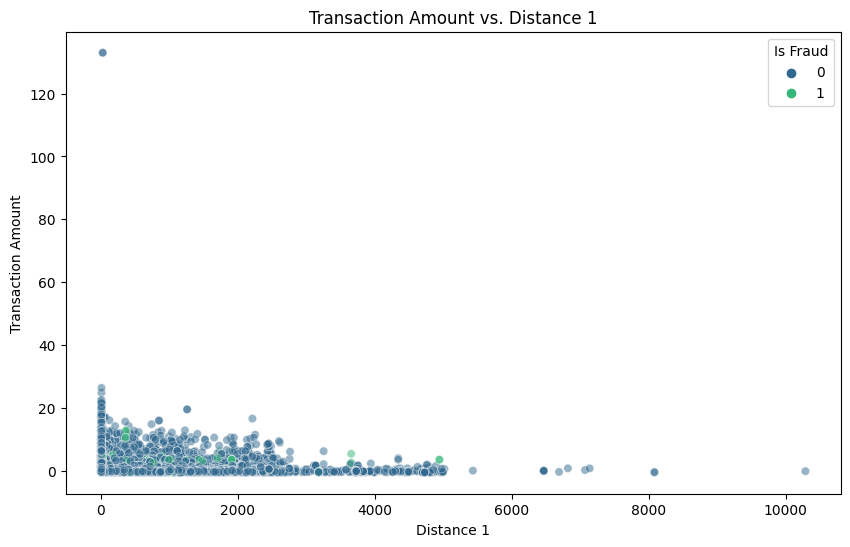

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dist1', y='TransactionAmt', hue='isFraud', data=data, palette='viridis', alpha=0.5)
plt.title('Transaction Amount vs. Distance 1')
plt.xlabel('Distance 1')
plt.ylabel('Transaction Amount')
plt.legend(title='Is Fraud')
plt.show()

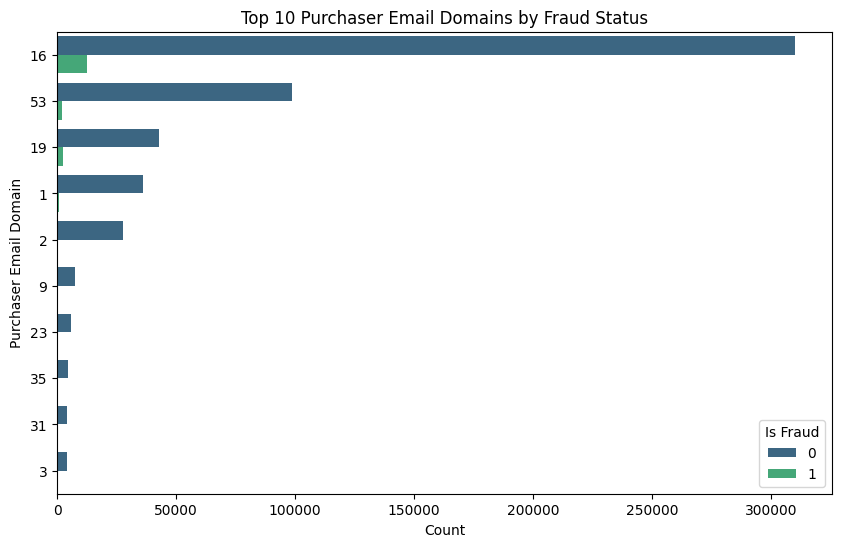

In [56]:
plt.figure(figsize=(10, 6))
sns.countplot(y='P_emaildomain', hue='isFraud', data=data, order=data['P_emaildomain'].value_counts().index[:10], palette='viridis')
plt.title('Top 10 Purchaser Email Domains by Fraud Status')
plt.xlabel('Count')
plt.ylabel('Purchaser Email Domain')
plt.legend(title='Is Fraud')
plt.show()

# ML models

In [57]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [58]:
lr_predictions = lr_model.predict(X_test)
print("Logistic Regression Report:\n", classification_report(y_test, lr_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_predictions))
lr_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:,1])
print("Logistic Regression AUC:", lr_auc)

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.70      0.77      0.73      4127
           1       0.74      0.67      0.70      4139

    accuracy                           0.72      8266
   macro avg       0.72      0.72      0.72      8266
weighted avg       0.72      0.72      0.72      8266

Confusion Matrix:
 [[3165  962]
 [1380 2759]]
Logistic Regression AUC: 0.7747782957539295


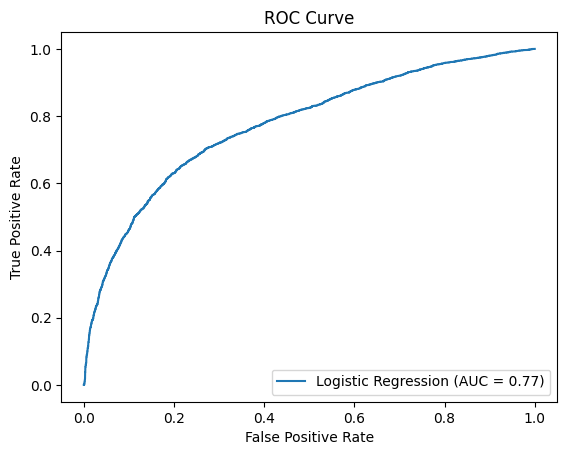

Model evaluation for Logistic Regression complete.


In [59]:
fpr, tpr, _ = roc_curve(y_test, lr_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(lr_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
print("Model evaluation for Logistic Regression complete.")

In [60]:
mlflow.set_experiment("Fraud Detection Models")

2024/10/23 01:15:45 INFO mlflow.tracking.fluent: Experiment with name 'Fraud Detection Models' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///kaggle/working/mlruns/462182098871801239', creation_time=1729646145789, experiment_id='462182098871801239', last_update_time=1729646145789, lifecycle_stage='active', name='Fraud Detection Models', tags={}>

In [61]:
learning_rate = 0.1  
epochs = 10
n_estimators = 100  
max_depth = 3

In [62]:
with mlflow.start_run(run_name="Logistic Regression"):
    # Log hyperparameters
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("epochs", epochs)

    # Initialize Logistic Regression model with warm start to train incrementally
    model = LogisticRegression( max_iter=1, random_state = 42)

    # Training loop across defined epochs
    for epoch in range(epochs):
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        # Log metrics for each epoch
        mlflow.log_metric("accuracy", accuracy, step=epoch)
        mlflow.log_metric("precision", precision, step=epoch)
        mlflow.log_metric("recall", recall, step=epoch)
        mlflow.log_metric("f1_score", f1, step=epoch)
        mlflow.log_metric("roc_auc", roc_auc, step=epoch)

        print(f"Epoch {epoch + 1}/{epochs} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f} - ROC AUC: {roc_auc:.4f}")

    # Log classification report and confusion matrix at the end of training
    print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))
    print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Save model
    model_filename = "logistic_regression_model1"

    # Save the model as an artifact in MLflow
    mlflow.sklearn.save_model(model, model_filename)
    mlflow.log_artifact(model_filename)

print("Run complete. Check MLflow UI for details.")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/10 - Accuracy: 0.5006 - Precision: 0.5007 - Recall: 0.9998 - F1: 0.6672 - ROC AUC: 0.5552


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 2/10 - Accuracy: 0.5006 - Precision: 0.5007 - Recall: 0.9998 - F1: 0.6672 - ROC AUC: 0.5552


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 3/10 - Accuracy: 0.5006 - Precision: 0.5007 - Recall: 0.9998 - F1: 0.6672 - ROC AUC: 0.5552


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 4/10 - Accuracy: 0.5006 - Precision: 0.5007 - Recall: 0.9998 - F1: 0.6672 - ROC AUC: 0.5552


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 5/10 - Accuracy: 0.5006 - Precision: 0.5007 - Recall: 0.9998 - F1: 0.6672 - ROC AUC: 0.5552


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 6/10 - Accuracy: 0.5006 - Precision: 0.5007 - Recall: 0.9998 - F1: 0.6672 - ROC AUC: 0.5552


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 7/10 - Accuracy: 0.5006 - Precision: 0.5007 - Recall: 0.9998 - F1: 0.6672 - ROC AUC: 0.5552


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 8/10 - Accuracy: 0.5006 - Precision: 0.5007 - Recall: 0.9998 - F1: 0.6672 - ROC AUC: 0.5552


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 9/10 - Accuracy: 0.5006 - Precision: 0.5007 - Recall: 0.9998 - F1: 0.6672 - ROC AUC: 0.5552


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 10/10 - Accuracy: 0.5006 - Precision: 0.5007 - Recall: 0.9998 - F1: 0.6672 - ROC AUC: 0.5552
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      4127
           1       0.50      1.00      0.67      4139

    accuracy                           0.50      8266
   macro avg       0.25      0.50      0.33      8266
weighted avg       0.25      0.50      0.33      8266

Logistic Regression Confusion Matrix:
 [[   0 4127]
 [   1 4138]]


2024/10/23 01:15:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: logistic_regression_model1/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.2.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 


Run complete. Check MLflow UI for details.


In [63]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [64]:
rf_predictions = rf_model.predict(X_test)
print("Random Forest Classifier Report:\n", classification_report(y_test, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1])
print("Random Forest AUC:", rf_auc)

Random Forest Classifier Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      4127
           1       0.87      0.83      0.85      4139

    accuracy                           0.85      8266
   macro avg       0.85      0.85      0.85      8266
weighted avg       0.85      0.85      0.85      8266

Confusion Matrix:
 [[3604  523]
 [ 717 3422]]
Random Forest AUC: 0.9260714697810569


In [65]:
with mlflow.start_run(run_name="Random Forest Classifier"):
    # Log hyperparameters
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("random_state", 42)

    # Initialize Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Training loop across defined epochs
    for epoch in range(epochs):
        rf_model.fit(X_train, y_train)

        # Make predictions
        rf_predictions = rf_model.predict(X_test)
        rf_proba = rf_model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, rf_predictions)
        precision = precision_score(y_test, rf_predictions)
        recall = recall_score(y_test, rf_predictions)
        f1 = f1_score(y_test, rf_predictions)
        roc_auc = roc_auc_score(y_test, rf_proba)

        # Log metrics for each epoch
        mlflow.log_metric("accuracy", accuracy, step=epoch)
        mlflow.log_metric("precision", precision, step=epoch)
        mlflow.log_metric("recall", recall, step=epoch)
        mlflow.log_metric("f1_score", f1, step=epoch)
        mlflow.log_metric("roc_auc", roc_auc, step=epoch)

        print(f"Epoch {epoch + 1}/{epochs} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f} - ROC AUC: {roc_auc:.4f}")

    # Log classification report and confusion matrix at the end of training
    print("Random Forest Classifier Report:\n", classification_report(y_test, rf_predictions))
    print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))

    # Save the model as an artifact in MLflow
    model_filename = "random_forest_model1"
    mlflow.sklearn.save_model(rf_model, model_filename)
    mlflow.log_artifact(model_filename)

print("Run complete. Check MLflow UI for details.")
   

Epoch 1/10 - Accuracy: 0.8500 - Precision: 0.8674 - Recall: 0.8268 - F1: 0.8466 - ROC AUC: 0.9261
Epoch 2/10 - Accuracy: 0.8500 - Precision: 0.8674 - Recall: 0.8268 - F1: 0.8466 - ROC AUC: 0.9261
Epoch 3/10 - Accuracy: 0.8500 - Precision: 0.8674 - Recall: 0.8268 - F1: 0.8466 - ROC AUC: 0.9261
Epoch 4/10 - Accuracy: 0.8500 - Precision: 0.8674 - Recall: 0.8268 - F1: 0.8466 - ROC AUC: 0.9261
Epoch 5/10 - Accuracy: 0.8500 - Precision: 0.8674 - Recall: 0.8268 - F1: 0.8466 - ROC AUC: 0.9261
Epoch 6/10 - Accuracy: 0.8500 - Precision: 0.8674 - Recall: 0.8268 - F1: 0.8466 - ROC AUC: 0.9261
Epoch 7/10 - Accuracy: 0.8500 - Precision: 0.8674 - Recall: 0.8268 - F1: 0.8466 - ROC AUC: 0.9261
Epoch 8/10 - Accuracy: 0.8500 - Precision: 0.8674 - Recall: 0.8268 - F1: 0.8466 - ROC AUC: 0.9261
Epoch 9/10 - Accuracy: 0.8500 - Precision: 0.8674 - Recall: 0.8268 - F1: 0.8466 - ROC AUC: 0.9261
Epoch 10/10 - Accuracy: 0.8500 - Precision: 0.8674 - Recall: 0.8268 - F1: 0.8466 - ROC AUC: 0.9261
Random Forest Class

2024/10/23 01:19:05 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: random_forest_model1/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.2.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 


Run complete. Check MLflow UI for details.


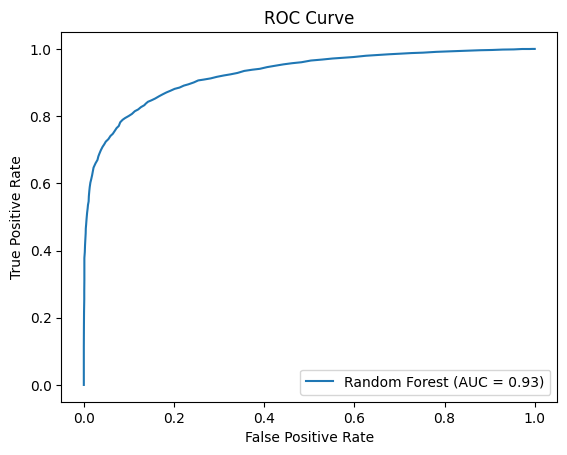

Model evaluation for Random Forest complete.


In [66]:
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(rf_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print("Model evaluation for Random Forest complete.")

In [67]:
non_fraud_count = sum(y_train == 0)
fraud_count = sum(y_train == 1)
scale_pos_weight = non_fraud_count / fraud_count

# XGBoost Model with scale_pos_weight
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)

In [68]:
param_dist = {
    'n_estimators': [100, 200, 300],     
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [3, 5, 7],             
    'subsample': [0.7, 0.8, 1.0],       
    'colsample_bytree': [0.7, 0.8, 1.0] 
}


# RandomizedSearchCV for hyperparameter tuning
random_search_xgb = RandomizedSearchCV(xgb_model, param_dist, n_iter=10, cv=3, scoring='f1', verbose=2, random_state=42)
random_search_xgb.fit(X_train, y_train)

# Best model from random search
best_xgb_model = random_search_xgb.best_estimator_

# Predicting on the test set
y_pred_xgb = best_xgb_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred_xgb))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.7; total time=  12.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.7; total time=  13.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.7; total time=  12.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.7; total time=   5.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.7; total time=   5.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.7; total time=   7.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   6.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   6.9s
[CV] END cols

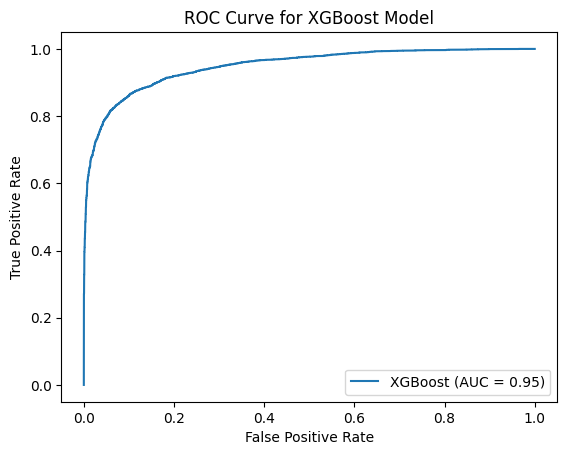

Model evaluation for XGBoost complete.


In [69]:
y_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.2f})'.format(roc_auc_xgb))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend(loc='lower right')
plt.show()

print("Model evaluation for XGBoost complete.")

In [70]:
with mlflow.start_run(run_name="XGBoost Classifier"):
    # RandomizedSearchCV for hyperparameter tuning
    random_search_xgb = RandomizedSearchCV(xgb_model, param_dist, n_iter=10, cv=3, scoring='f1', verbose=2, random_state=42)
    random_search_xgb.fit(X_train, y_train)

    # Log the best hyperparameters
    best_params = random_search_xgb.best_params_
    for param, value in best_params.items():
        mlflow.log_param(param, value)

    # Best model from random search
    best_xgb_model = random_search_xgb.best_estimator_

    # Predict on the test set
    y_pred_xgb = best_xgb_model.predict(X_test)
    y_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_xgb)
    precision = precision_score(y_test, y_pred_xgb)
    recall = recall_score(y_test, y_pred_xgb)
    f1 = f1_score(y_test, y_pred_xgb)
    roc_auc = roc_auc_score(y_test, y_proba_xgb)

    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc_auc)

    print(f"XGBoost Classifier - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f} - ROC AUC: {roc_auc:.4f}")

    # Log classification report and confusion matrix
    print("XGBoost Classifier Report:\n", classification_report(y_test, y_pred_xgb))
    print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

    # Save the model as an artifact in MLflow
    model_filename = "xgboost_model1"
    mlflow.sklearn.save_model(best_xgb_model, model_filename)
    mlflow.log_artifact(model_filename)

print("Run complete. Check MLflow UI for details.")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.7; total time=  13.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.7; total time=  12.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.7; total time=  12.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.7; total time=   7.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.7; total time=   5.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.7; total time=   5.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   6.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   6.8s
[CV] END cols

2024/10/23 01:26:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: xgboost_model1/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.2.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 


Run complete. Check MLflow UI for details.
